### Attention  
#### 1,核心公式与物理含义  

Attention的本质是：模型应该更关注输入中的重要部分，忽略不重要的部分  
$$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$$


  

- 点积：${QK^T}$ 用于计算Q和K的相似度得分   

- 缩放因子：$\sqrt{d_k}$ 用于防止Q和K的维度过大，导致计算结果过大 

- softmax：将相似度得分进行归一化，使得相似度得分的分布更加平滑，从而实现对输入的关注

#### 具象化理解  
假设输入序列为[我，吃，苹果]，观察Token"苹果“是如何通过Attention确定自己为水果而不是手机  
- Q：Token询问上下文有没有词语可以确定其身份  
- K: ”吃“是进食的标签，因此，苹果为物体（水果/电子产品）  
- V：”吃“提供的具体信息为”吞咽，食物属性“，因此，苹果为水果，不是手机 

#### 2, 掩码与权重  
假设输入为[I,love,coding]  
目标任务：模型计算自注意力权重，理解每个词之间的关系  


- 计算原始相似度得分  
假设模型计算出的原始得分矩阵如下：  
数值越大表示越相关  

|        | I    | love | coding |
| ------ | ---- | ---- | ------ |
| I      | 10   | 8    | 5      |
| love   | 7    | 12   | 9      |
| coding | 6    | 8    | 15     |  

此时，第一行显示I认为自己和Love,coding都有关系。但在生成式模型中，这是不允许的

- 添加因果掩码  
将所有的“未来位置”设置为负无穷  
得分矩阵变换为  

|        | I    | love | coding |
| ------ | ---- | ---- | ------ |
| I      | 10   | -inf    | -inf       |
| love   | 7    | 12   |-inf      |
| coding | 6    | 8    | 15     |  

- 通过softmax转换为最终权重 
最后，模型会对每一行进行softmax，得到最终的预测结果    

|        | I    | love | coding |
| ------ | ---- | ---- | ------ |
| I      | 1.00   | 0.00   | 0.00        |
| love   | 0.01    | 0.99   |0.00      |
| coding | 0.00 | 0.00   | 0.99   |  


In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
batch_size=2  
seq_len=5 
d_model=16 
x=torch.randn(batch_size, seq_len, d_model)  # (B, S, D)
print(x.shape)

torch.Size([2, 5, 16])


In [4]:
#定义QKV线性变换
W_q=nn.Linear(d_model,d_model) 
W_k=nn.Linear(d_model,d_model)
W_v=nn.Linear(d_model,d_model)

for layer in [W_q,W_k,W_v]:
    nn.init.xavier_uniform_(layer.weight)
    nn.init.constant_(layer.bias,0)  

Q=W_q(x)  #(B,S,D)
K=W_k(x)  #(B,S,D)
V=W_v(x)  #(B,S,D)
print(Q.shape,K.shape,V.shape)


torch.Size([2, 5, 16]) torch.Size([2, 5, 16]) torch.Size([2, 5, 16])


In [13]:
#计算注意力分数  
d_k=K.shape[-1]
scale=torch.sqrt(torch.tensor(d_k,dtype=torch.float32))
atten_score=torch.matmul(Q,K.transpose(-2,-1))/scale
print(atten_score.shape)  #(B,S,S)
print(f"原始注意力分数（未掩码，保留3位小数）：\n{torch.round(atten_score[0], decimals=3)}") 

torch.Size([2, 5, 5])
原始注意力分数（未掩码，保留3位小数）：
tensor([[ 1.4450, -0.3430,  0.7040, -1.4100,  1.0890],
        [ 0.0530, -1.1430,  0.2860,  0.1440, -0.3520],
        [ 0.9720, -0.3010, -0.2660,  0.5250,  2.5400],
        [-1.3370, -1.0670, -0.6030,  1.3230, -1.2380],
        [-0.0410, -1.8440,  1.8780,  0.8320, -0.8090]],
       grad_fn=<RoundBackward1>)


In [17]:
#生成因果掩码 
mask=torch.ones(seq_len,seq_len)
casual_mask=torch.triu(mask,1)
causal_mask=casual_mask.bool()  #(S,S)
print(f"因果掩码形状：{causal_mask.shape}")
print(f"因果掩码矩阵（True=屏蔽，False=保留）：\n{causal_mask}")

因果掩码形状：torch.Size([5, 5])
因果掩码矩阵（True=屏蔽，False=保留）：
tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


In [18]:
#应用因果掩码到注意力分数+可视化  
masked_value=-1e9
atten_scores_masked=atten_score.masked_fill(causal_mask,masked_value)
print(f"掩码后注意力分数（保留3位小数）：\n{torch.round(atten_scores_masked[0], decimals=3)}")

掩码后注意力分数（保留3位小数）：
tensor([[ 1.4450e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 5.3000e-02, -1.1430e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 9.7200e-01, -3.0100e-01, -2.6600e-01, -1.0000e+09, -1.0000e+09],
        [-1.3370e+00, -1.0670e+00, -6.0300e-01,  1.3230e+00, -1.0000e+09],
        [-4.1000e-02, -1.8440e+00,  1.8780e+00,  8.3200e-01, -8.0900e-01]],
       grad_fn=<RoundBackward1>)


In [21]:
#计算softmax
atten_weights=F.softmax(atten_scores_masked,dim=-1)  #(B,S,S)
row_sums=torch.sum(atten_weights[0],dim=-1)
print(f"注意力权重形状：{atten_weights.shape}")
print(f"注意力权重矩阵（保留3位小数，上三角全0=掩码生效）：\n{torch.round(atten_weights[0], decimals=3)}")
print(f"每行权重和（验证Softmax归一化，应均为1，保留3位小数）：\n{torch.round(row_sums, decimals=3)}")

注意力权重形状：torch.Size([2, 5, 5])
注意力权重矩阵（保留3位小数，上三角全0=掩码生效）：
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7680, 0.2320, 0.0000, 0.0000, 0.0000],
        [0.6370, 0.1780, 0.1850, 0.0000, 0.0000],
        [0.0530, 0.0700, 0.1110, 0.7650, 0.0000],
        [0.0920, 0.0150, 0.6290, 0.2210, 0.0430]], grad_fn=<RoundBackward1>)
每行权重和（验证Softmax归一化，应均为1，保留3位小数）：
tensor([1., 1., 1., 1., 1.], grad_fn=<RoundBackward1>)


In [23]:
#输出最终注意力输出 
attn_output = torch.matmul(atten_weights, V)
print(f"注意力输出形状：{attn_output.shape}")  #(B,S,D)
print(f"注意力输出（保留3位小数）：\n{torch.round(attn_output[0], decimals=3)}")

注意力输出形状：torch.Size([2, 5, 16])
注意力输出（保留3位小数）：
tensor([[ 0.3330,  0.9460,  0.2280,  1.7240,  1.0060,  1.7780,  1.2070, -0.0620,
          0.1130, -0.8680,  0.0940, -0.3070, -0.8920, -0.9880, -0.8180,  1.2110],
        [ 0.3100,  0.9430,  0.1330,  1.3640,  0.5010,  1.2970,  0.8330,  0.2060,
         -0.0120, -0.8430,  0.1680, -0.6020, -1.0720, -1.0190, -0.7620,  0.5940],
        [ 0.2420,  0.1670,  0.0620,  1.1800,  0.6300,  1.5290,  0.8090,  0.2620,
         -0.1990, -0.8890, -0.0100, -0.3230, -0.7820, -0.3990, -0.5880,  0.8150],
        [-0.0930, -0.4380, -1.0290, -0.5650, -1.5670, -0.2400,  0.8650,  1.0100,
         -0.2620, -1.1440, -0.8550,  1.1260,  0.1780,  0.4050,  1.2330,  0.1980],
        [ 0.0280, -1.9330, -0.4810,  0.1360,  0.2520,  1.4960,  0.7080,  0.7250,
         -0.7400, -1.1690, -0.7030,  0.8170,  0.1660,  1.3510,  0.3460,  1.0450]],
       grad_fn=<RoundBackward1>)


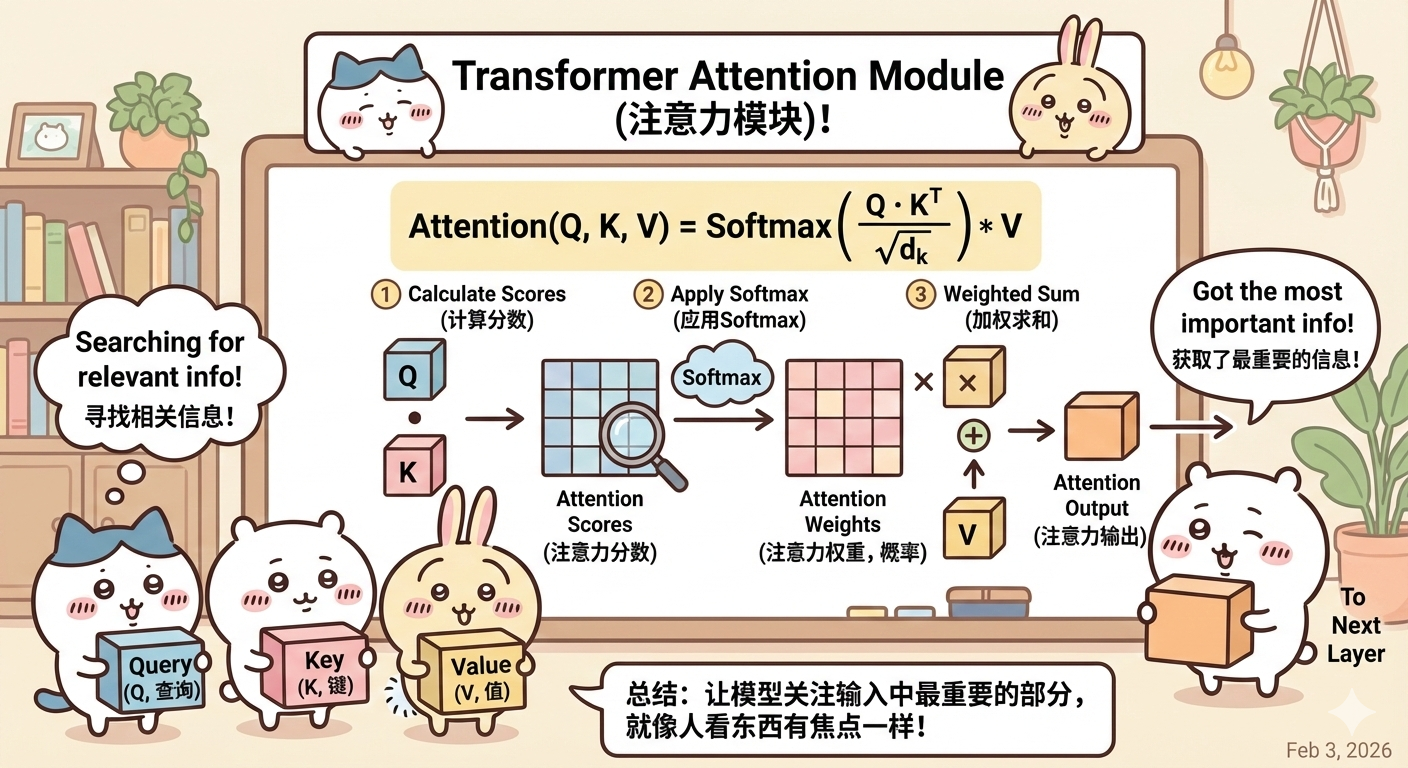